In [1]:
import pandas as pd
import numpy as np

# Loading the datasets
gdf_path = 'gdf.csv'
neighborhoods_path = 'neighborhoods.csv'

# Reading the files
gdf_df = pd.read_csv(gdf_path)
neighborhoods_df = pd.read_csv(neighborhoods_path)

# Displaying the first few rows of each dataset to understand their structure
gdf_df.head()

,ID,Time,StrippedMessage,PrioLevel,Service,LifeLiner,Municipality,Latitude,Longitude,geometry,...,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,AF_ZIEK_E,P_WEST_AL,P_N_W_AL,P_LKOOPKRH,P_SOCMINH
0,13558559,2018-01-01 00:09:26,Voertuignummer: 17143 Ritnummer: 3,2,Ambulance,False,Rotterdam,51.913285,4.468674,POINT (91801.97938507967 436487.2364907257),...,5.0,31.0,49.0,9.0,6.0,0.8,14.0,38.0,7.0,6.0
1,13558603,2018-01-01 00:14:44,(Directe inzet) Voertuignummer: 17141 Ritnumme...,2,Ambulance,False,Rotterdam,51.924087,4.495399,POINT (93655.47582858041 437666.12130516244),...,13.0,18.0,35.0,20.0,15.0,1.2,14.0,41.0,16.0,16.0
2,13558607,2018-01-01 00:15:01,Voertuignummer: 17135 Ritnummer: 5,2,Ambulance,False,Rotterdam,51.911128,4.454299,POINT (90809.92813429012 436259.92204458866),...,17.0,17.0,33.0,23.0,9.0,1.9,12.0,55.0,21.0,20.0
3,13558626,2018-01-01 00:17:58,Voertuignummer: 17125 Erasmusbrug Ritnummer: 6,2,Ambulance,False,Rotterdam,51.924216,4.481776,POINT (92718.57441649365 437692.0589595595),...,8.0,15.0,46.0,19.0,11.0,1.0,20.0,29.0,8.0,7.0
4,13558636,2018-01-01 00:19:27,(Directe inzet) Voertuignummer: 17117 Ritnumme...,2,Ambulance,False,Rotterdam,51.904196,4.498897,POINT (93869.0466891996 435450.3019508433),...,18.0,16.0,28.0,25.0,13.0,2.0,7.0,79.0,29.0,28.0


In [2]:
gdf_df.columns

Index(['ID', 'Time', 'StrippedMessage', 'PrioLevel', 'Service', 'LifeLiner',
       'Municipality', 'Latitude', 'Longitude', 'geometry', 'Shape_Leng',
       'Shape_Area', 'BU_NAAM', 'INK_INW2', 'AANT_INW', 'BEV_DICHTH',
       'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR', 'P_45_64_JR', 'P_65_EO_JR',
       'AF_ZIEK_E', 'P_WEST_AL', 'P_N_W_AL', 'P_LKOOPKRH', 'P_SOCMINH'],
      dtype='object')

In [3]:
neighborhoods_df.head()

,BU_NAAM,geometry
0,Stadsdriehoek,"POLYGON ((92349.57999999821 437925.0560000017,..."
1,Oude Westen,POLYGON ((91412.78819999844 437507.73999999836...
2,Cool,"POLYGON ((91925.5 437499.71020000055, 91933.68..."
3,Cs Kwartier,"POLYGON ((92326.07800000161 437923.1099999994,..."
4,Nieuwe Werk,POLYGON ((92374.74799999967 436289.95800000057...


In [4]:
# Calculating the average response time and total call count for each neighborhood
neighborhood_agg = gdf_df.groupby('BU_NAAM').agg(
    CallCount=('ID', 'count')
).reset_index()

# Merging aggregated data with socio-economic variables
merged_data = pd.merge(neighborhood_agg, gdf_df[['BU_NAAM', 'INK_INW2', 'BEV_DICHTH', 'P_N_W_AL', 'P_SOCMINH', 'AF_ZIEK_E']].drop_duplicates(), on='BU_NAAM', how='left')

# Checking the merged dataset
merged_data.head()

,BU_NAAM,CallCount,INK_INW2,BEV_DICHTH,P_N_W_AL,P_SOCMINH,AF_ZIEK_E
0,'s Gravenland,467,37.0,3979.0,21.0,4.0,2.3
1,Afrikaanderwijk,848,16.0,14058.0,79.0,28.0,2.0
2,Agniesebuurt,441,21.0,11289.0,54.0,20.0,1.9
3,Bedrijvenpark Noord-West,47,-99999999.0,9.0,-99999999.0,-99999999.0,4.7
4,Bergpolder,271,28.0,18100.0,26.0,11.0,1.0


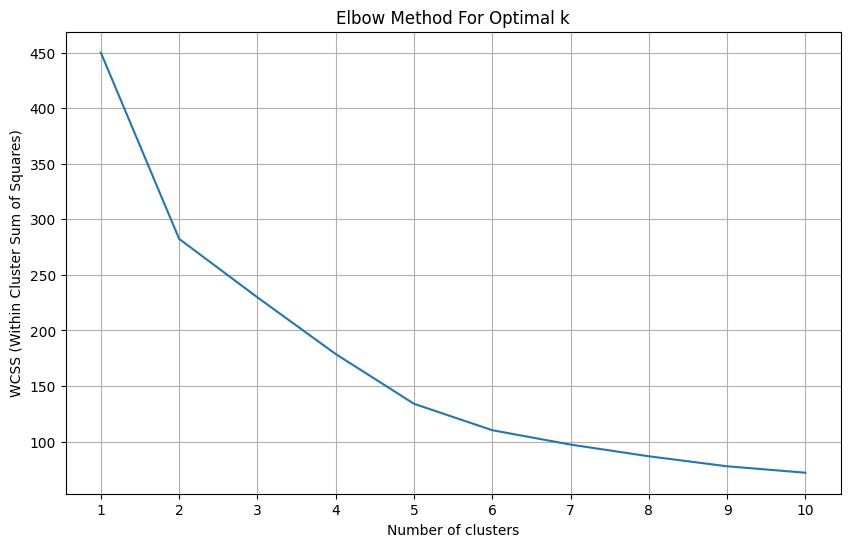

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Handling placeholder or erroneous values in the dataset
merged_data.replace(-99999999, np.nan, inplace=True)
merged_data.dropna(inplace=True)

# Selecting relevant columns for clustering
clustering_features = ['INK_INW2', 'BEV_DICHTH', 'P_N_W_AL', 'P_SOCMINH', 'AF_ZIEK_E', 'CallCount']

# Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data[clustering_features])

# Determining the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [6]:
# Performing K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(scaled_data)

# Adding the cluster labels to the dataset
merged_data['Cluster'] = cluster_labels

'INK_INW2': 'Income_per_inhabitant'

'BEV_DICHTH': 'Population_density',

'P_N_W_AL': 'percentage_of_non_western_inhabitants',

'P_SOCMINH': 'percentage_households_living_under_the_social_minimum',

'AF_ZIEK_E': 'Distance_to_hospital'

In [7]:
import geopandas as gpd
import seaborn as sns

# Renaming columns as requested
rename_columns = {
    'INK_INW2': 'Income_per_inhabitant',
    'BEV_DICHTH': 'Population_density',
    'P_N_W_AL': 'Percentage_of_non_western_inhabitants',
    'P_SOCMINH': 'Percentage_households_living_under_the_social_minimum',
    'AF_ZIEK_E': 'Distance_to_hospital'
}
merged_data.rename(columns=rename_columns, inplace=True)

In [8]:
merged_data.head()

,BU_NAAM,CallCount,Income_per_inhabitant,Population_density,Percentage_of_non_western_inhabitants,Percentage_households_living_under_the_social_minimum,Distance_to_hospital,Cluster
0,'s Gravenland,467,37.0,3979.0,21.0,4.0,2.3,2
1,Afrikaanderwijk,848,16.0,14058.0,79.0,28.0,2.0,1
2,Agniesebuurt,441,21.0,11289.0,54.0,20.0,1.9,1
4,Bergpolder,271,28.0,18100.0,26.0,11.0,1.0,1
5,Beverwaard,792,19.0,8122.0,51.0,14.0,3.8,1


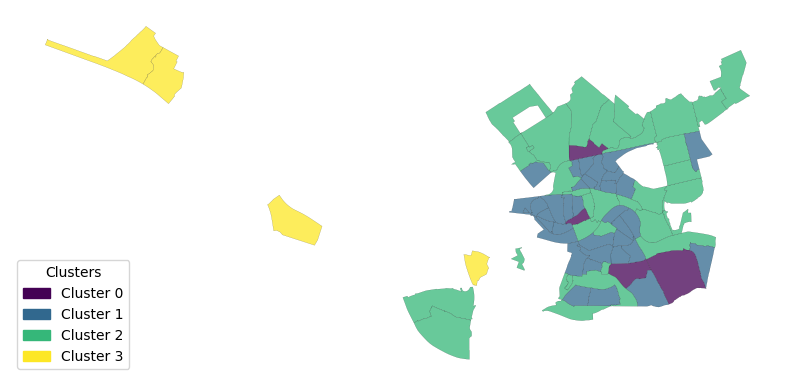

In [9]:
from shapely import wkt

# Converting 'geometry' column from string to geometric objects
neighborhoods_df['geometry'] = neighborhoods_df['geometry'].apply(wkt.loads)
neighborhoods_gdf = gpd.GeoDataFrame(neighborhoods_df, geometry='geometry')

# Merging the clustering results with the geographical data
choropleth_data = neighborhoods_gdf.merge(merged_data, on='BU_NAAM')

# Plotting the choropleth map for the clusters
fig, ax = plt.subplots(figsize=(10, 10))
choropleth_data.plot(ax=ax, column='Cluster', alpha=0.75, k=5, categorical=True,
               cmap='viridis', edgecolor='black',linewidth=0.1,  missing_kwds={'color': 'lightgray', 'edgecolor': 'black'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax.set_axis_off()

# Creating a legend manually
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Creating color map
cmap = plt.cm.viridis
norm = Normalize(vmin=choropleth_data['Cluster'].min(), vmax=choropleth_data['Cluster'].max())
n_cmap = ScalarMappable(norm=norm, cmap=cmap)

# Creating legend patches
legend_patches = [mpatches.Patch(color=n_cmap.to_rgba(i), label=f'Cluster {i}') for i in range(int(choropleth_data['Cluster'].max()) + 1)]
ax.legend(handles=legend_patches, loc='lower left', title='Clusters')

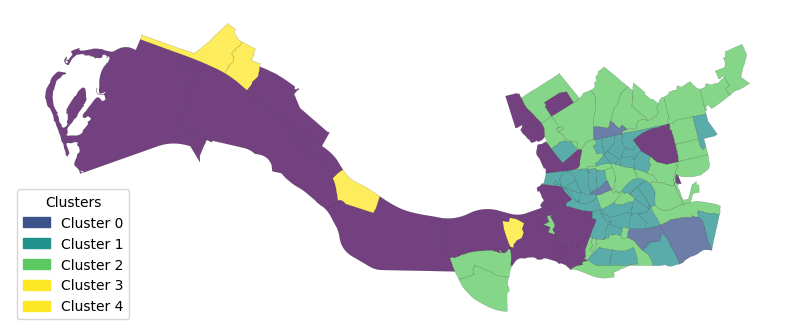

In [10]:
# Step 2: Merge the geographic data with the clustering results
# Use a left join to ensure all neighborhoods are included, even those without clustering data
complete_choropleth_data = neighborhoods_gdf.merge(merged_data, on='BU_NAAM', how='left')

# For neighborhoods with no data, set the Cluster to a distinct number, e.g., -1
complete_choropleth_data['Cluster'].fillna(-1, inplace=True)

# Step 3: Plot the choropleth map again with the adjustments

# Define the color map and norm for the clusters, including the 'no data' cluster (-1)
cmap = plt.cm.viridis
norm = Normalize(vmin=complete_choropleth_data['Cluster'].min(), vmax=complete_choropleth_data['Cluster'].max())
n_cmap = ScalarMappable(norm=norm, cmap=cmap)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
complete_choropleth_data.plot(ax=ax, column='Cluster', alpha=0.75, categorical=True,
                              cmap=cmap, edgecolor='black', linewidth=0.1,
                              missing_kwds={'color': 'lightgray', 'edgecolor': 'black', 'label': 'No data'})

# Create legend patches including the 'no data' category
legend_patches = [mpatches.Patch(color=n_cmap.to_rgba(i), label=f'Cluster {i}' if i >= 0 else 'No data')
                  for i in range(int(complete_choropleth_data['Cluster'].max()) + 2)]  # +2 to include the 'no data' category

# Add legend to the plot
ax.legend(handles=legend_patches, loc='lower left', title='Clusters')

# Remove axes
ax.set_axis_off()

# Show the plot
plt.show()


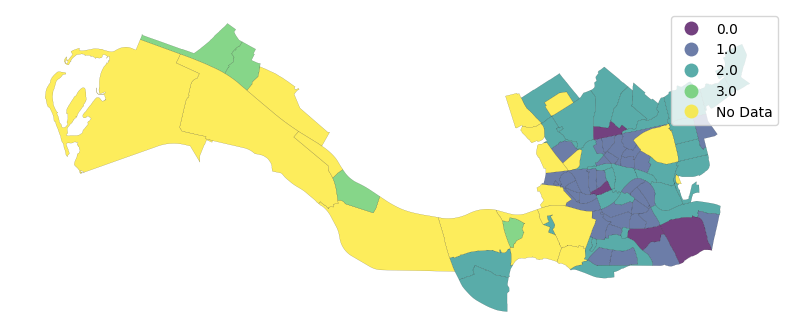

In [11]:
# Rename the 'Cluster 4' to 'No Data' for meaningful representation
complete_choropleth_data['Cluster'] = complete_choropleth_data['Cluster'].replace(-1, 'No Data')

missing_kwds = {
    'color': 'lightgray',
    'edgecolor': 'black',
    'hatch': '///',
    'label': 'No data'
}

# Plot the map again with the updated cluster names
fig, ax = plt.subplots(figsize=(10, 10))
complete_choropleth_data.plot(ax=ax, column='Cluster', alpha=0.75, categorical=True,
                              cmap=cmap, edgecolor='black', linewidth=0.1,
                              legend=True,  # Let geopandas handle the legend for categorical data
                              missing_kwds=missing_kwds)

# Remove axes
ax.set_axis_off()

# Show the plot
plt.show()

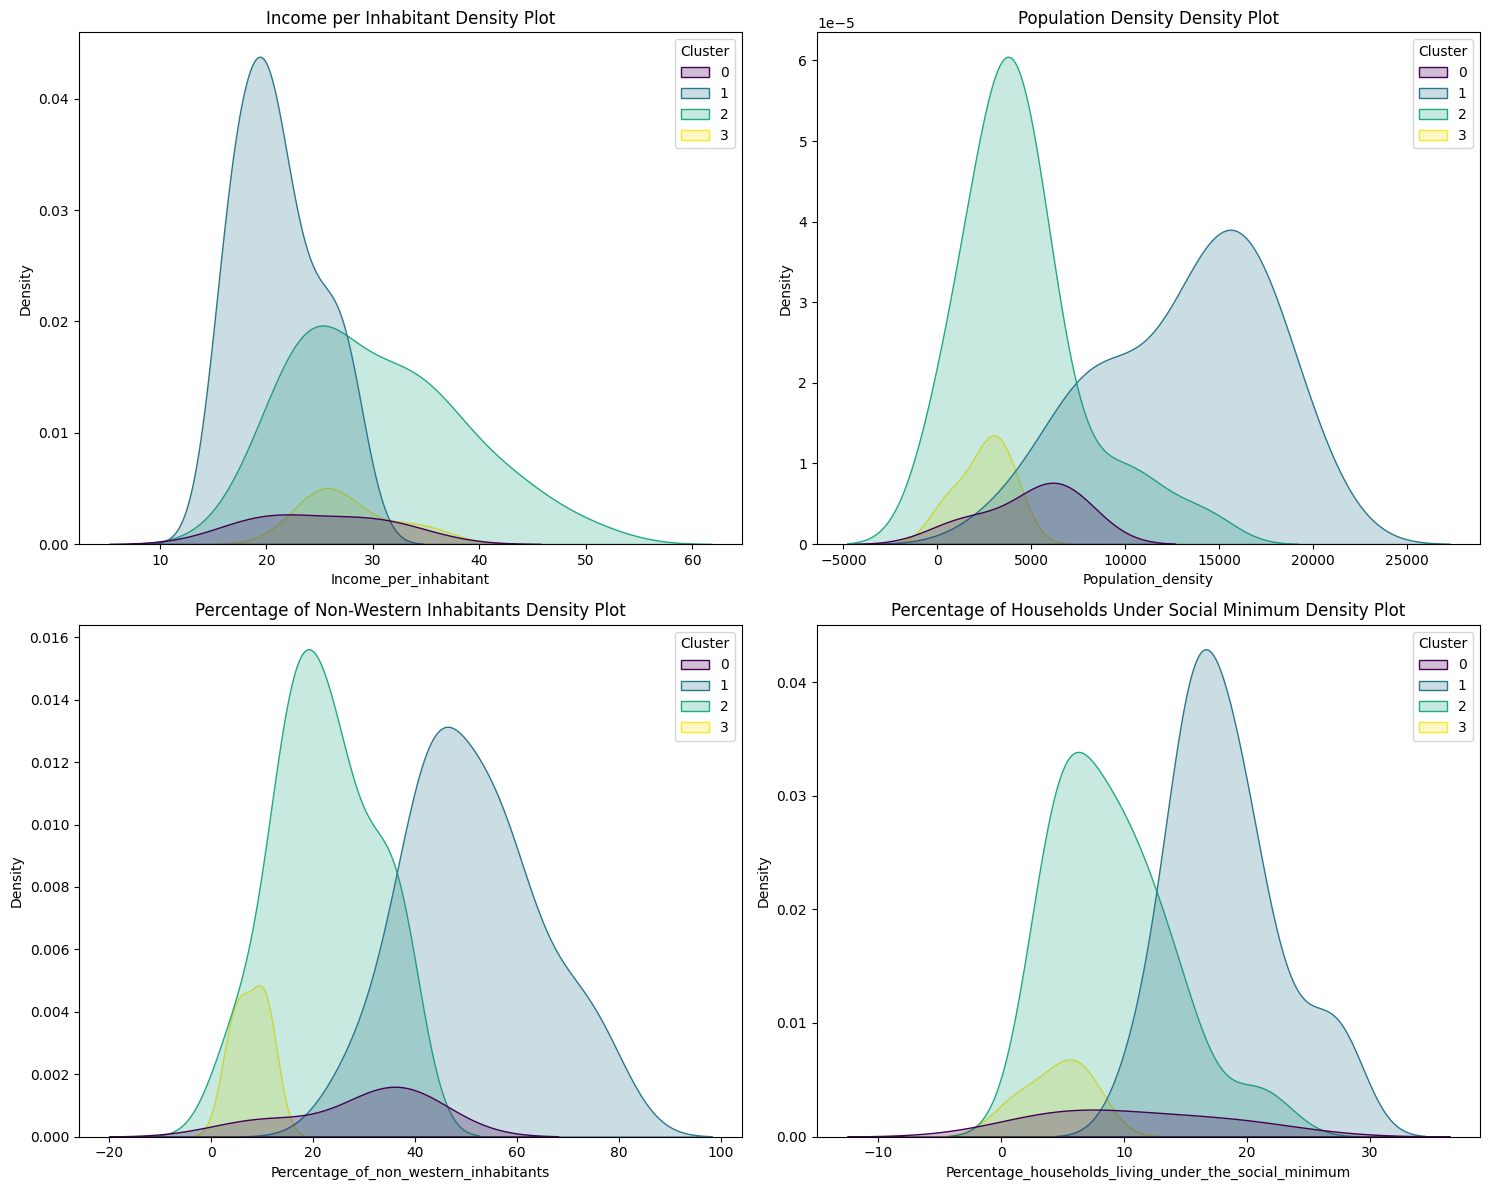

In [17]:
# Custom color palette
palette = ["#440154FF", "#2A788EFF", "#22A884FF", "#FDE725FF"]

# Plotting density plots for key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.kdeplot(data=merged_data, x='Income_per_inhabitant', hue='Cluster', ax=axes[0, 0], fill=True,palette=palette)
axes[0, 0].set_title('Income per Inhabitant Density Plot')

sns.kdeplot(data=merged_data, x='Population_density', hue='Cluster', ax=axes[0, 1], fill=True,palette=palette)
axes[0, 1].set_title('Population Density Density Plot')

sns.kdeplot(data=merged_data, x='Percentage_of_non_western_inhabitants', hue='Cluster', ax=axes[1, 0], fill=True,palette=palette)
axes[1, 0].set_title('Percentage of Non-Western Inhabitants Density Plot')

sns.kdeplot(data=merged_data, x='Percentage_households_living_under_the_social_minimum', hue='Cluster', ax=axes[1, 1], fill=True,palette=palette)
axes[1, 1].set_title('Percentage of Households Under Social Minimum Density Plot')

plt.tight_layout()
plt.show()

In [169]:
merged_data.head(40)

,BU_NAAM,AverageResponseTime,CallCount,Income_per_inhabitant,Population_density,Percentage_of_non_western_inhabitants,Percentage_households_living_under_the_social_minimum,Distance_to_hospital,Cluster
0,'s Gravenland,600.027837,467,37.0,3979.0,21.0,4.0,2.3,2
1,Afrikaanderwijk,484.298349,848,16.0,14058.0,79.0,28.0,2.0,1
2,Agniesebuurt,424.507937,441,21.0,11289.0,54.0,20.0,1.9,1
4,Bergpolder,532.538745,271,28.0,18100.0,26.0,11.0,1.0,1
5,Beverwaard,457.566919,792,19.0,8122.0,51.0,14.0,3.8,1
6,Blijdorp,480.433437,323,33.0,6240.0,14.0,6.0,1.6,2
8,Bloemhof,422.044912,1759,16.0,18067.0,64.0,22.0,1.1,1
9,Bospolder,473.523438,512,17.0,20687.0,69.0,24.0,2.1,1
11,Carnisse,536.132969,549,20.0,19420.0,39.0,11.0,1.4,1
12,Charlois Zuidrand,453.000000,177,31.0,239.0,14.0,9.0,3.6,2


C:\Users\Asus\AppData\Local\Temp\ipykernel_15800\113254564.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='CallCount', data=clustered_data, palette=palette)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15800\113254564.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Income_per_inhabitant', data=clustered_data, palette=palette)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15800\113254564.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Population_density', data=clustered_data, palette=p

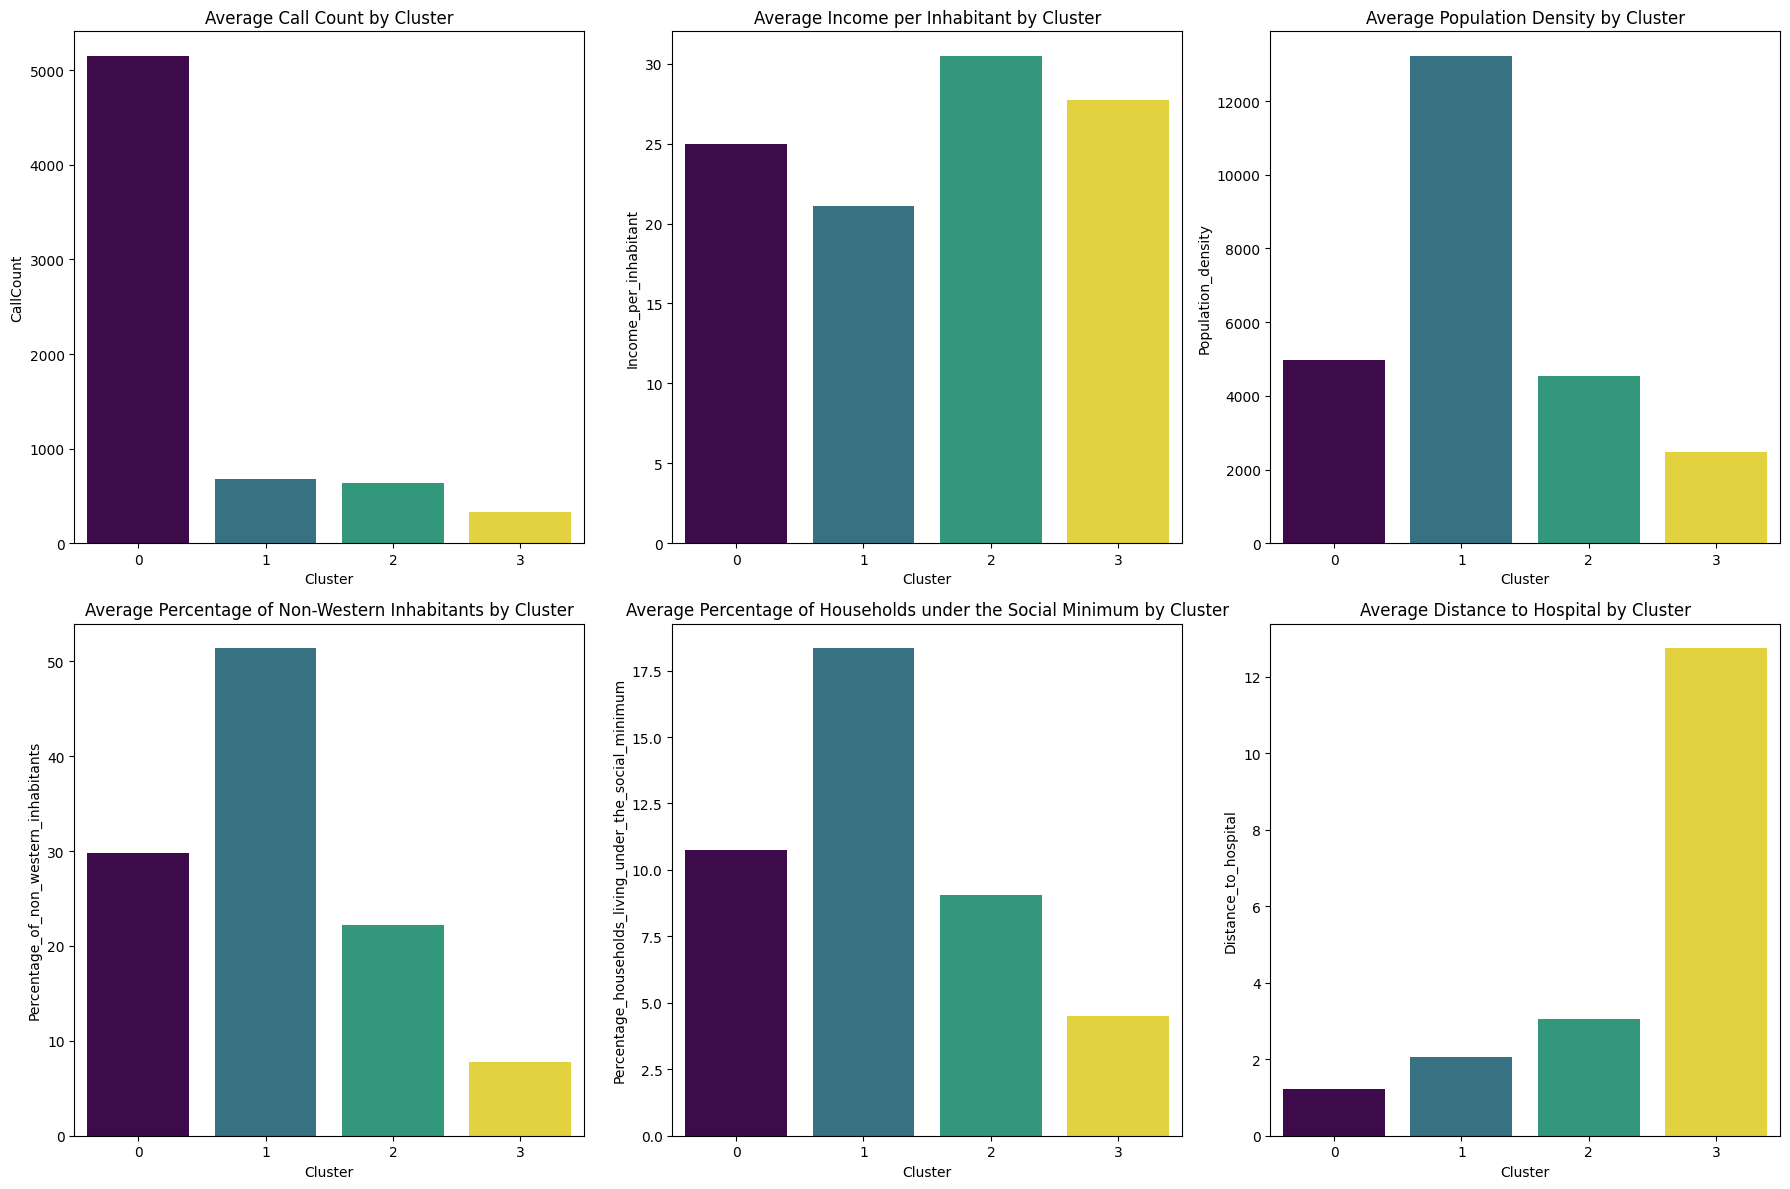

In [170]:
import seaborn as sns

# Preparing data for visualization
clustered_data = merged_data.groupby('Cluster').agg({
    'CallCount': 'mean',
    'Income_per_inhabitant': 'mean',
    'Population_density': 'mean',
    'Percentage_of_non_western_inhabitants': 'mean',
    'Percentage_households_living_under_the_social_minimum': 'mean',
    'Distance_to_hospital': 'mean'
}).reset_index()

# Visualizations
plt.figure(figsize=(18, 12))

# Call Count by Cluster
plt.subplot(2, 3, 1)
sns.barplot(x='Cluster', y='CallCount', data=clustered_data, palette=palette)
plt.title('Average Call Count by Cluster')

# Income per Inhabitant by Cluster
plt.subplot(2, 3, 2)
sns.barplot(x='Cluster', y='Income_per_inhabitant', data=clustered_data, palette=palette)
plt.title('Average Income per Inhabitant by Cluster')

# Population Density by Cluster
plt.subplot(2, 3, 3)
sns.barplot(x='Cluster', y='Population_density', data=clustered_data, palette=palette)
plt.title('Average Population Density by Cluster')

# Percentage of Non-Western Inhabitants by Cluster
plt.subplot(2, 3, 4)
sns.barplot(x='Cluster', y='Percentage_of_non_western_inhabitants', data=clustered_data, palette=palette)
plt.title('Average Percentage of Non-Western Inhabitants by Cluster')

# Percentage Households under Social Minimum by Cluster
plt.subplot(2, 3, 5)
sns.barplot(x='Cluster', y='Percentage_households_living_under_the_social_minimum', data=clustered_data, palette=palette)
plt.title('Average Percentage of Households under the Social Minimum by Cluster')

plt.subplot(2, 3, 6)
sns.barplot(x='Cluster', y='Distance_to_hospital', data=clustered_data, palette=palette)
plt.title('Average Distance to Hospital by Cluster')

plt.tight_layout()
plt.show()


In [1]:
# Let's check the version of GeoPandas used in this environment
import geopandas as gpd

gpd_version = gpd.__version__
gpd_version

'0.10.2'